In [3]:
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS  
import tensorflow as tf
import numpy as np
import cv2
import os
import json
from werkzeug.utils import secure_filename
from ultralytics import YOLO
import ollama

# Initialize Flask app
# app = Flask(__name__, template_folder=os.path.join("backend", "templates"), static_folder=os.path.join("backend", "static"))
app = Flask(__name__, template_folder="templates", static_folder="static")
CORS(app)  # Enable CORS for all routes
client = ollama.Client()

# Define paths
CLASSIFICATION_MODEL_DIR = os.path.join("models", "ensemble_model")
CLASS_LABELS_PATH = os.path.join("data", "class_labels.json")
SEGMENTATION_MODEL_PATH = os.path.join("models", "yolo_best.pt")
UPLOAD_FOLDER = os.path.join("data", "uploads")
LEAVES_FOLDER = os.path.join("data", "leaves")
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Load class labels
with open(CLASS_LABELS_PATH, "r") as json_file:
    class_labels = json.load(json_file)

# Load models
segmentation_model = YOLO(SEGMENTATION_MODEL_PATH)
classification_model = tf.saved_model.load(CLASSIFICATION_MODEL_DIR)
inference_func = classification_model.signatures["serving_default"]

In [12]:
def extract_leaves(results, image_path, output_dir=LEAVES_FOLDER):
    """
    Extracts segmented leaves from a YOLO model's results, saves them with a gray background,
    and returns the full file paths of the cropped leaves. If no leaves are detected, returns
    the original image path in a list.

    Args:
        results (list): YOLO model predictions.
        image_path (str): Path to the input image.
        output_dir (str): Directory to save the extracted leaves.

    Returns:
        list: List of file paths for saved leaf images. If no detections, returns [image_path].
    """

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load original image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (480, 640))

    saved_paths = []  # List to store output file paths
    
    # Get the masks
    mask_array = results[0].masks.data.cpu().numpy()  # (num_objects, height, width)
    
    # Loop through results (assuming single image inference)
    for i, mask in enumerate(mask_array):
        
        # Extract the leaf    
        mask = mask.astype(np.uint8) # Clip to 0-255
        result = cv2.bitwise_and(image, image, mask=mask) # Overlap with mask
        
        # Crop the result to the get exaclty the leaf while maintaining the leaf's proportion
        coords = cv2.findNonZero(mask) # Get coordinates of non-black pixels
        x, y, w, h = cv2.boundingRect(coords) # Get bounding box
        cropped_result = result[max(0, y-5):y+h+5, max(0, x-5):x+w+5]
        cropped_result = resize_with_padding(cropped_result)
        
        # Generate output file path
        output_filename = f"{os.path.basename(image_path).replace(".jpg", "")}_leaf_{i}.jpg"
        output_path = os.path.join(output_dir, output_filename)

        # Save the cropped leaf with gray background
        cv2.imwrite(output_path, cropped_result)

        # Store saved file path
        saved_paths.append(output_path)

    return saved_paths if len(saved_paths)!=0 else [image_path]  # Return original image if no leaves were saved

img_path = "/Users/myrios/Downloads/work_pls.webp"
results = segmentation_model.predict(source=img_path, conf=0.5, save=True, exist_ok=True)


image 1/1 /Users/myrios/Downloads/work_pls.webp: 640x480 9 leafs, 95.0ms
Speed: 4.2ms preprocess, 95.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict


In [13]:
extract_leaves(results, img_path)

['data/leaves/work_pls.webp_leaf_0.jpg',
 'data/leaves/work_pls.webp_leaf_1.jpg',
 'data/leaves/work_pls.webp_leaf_2.jpg',
 'data/leaves/work_pls.webp_leaf_3.jpg',
 'data/leaves/work_pls.webp_leaf_4.jpg',
 'data/leaves/work_pls.webp_leaf_5.jpg',
 'data/leaves/work_pls.webp_leaf_6.jpg',
 'data/leaves/work_pls.webp_leaf_7.jpg',
 'data/leaves/work_pls.webp_leaf_8.jpg']

(-0.5, 639.5, 852.5, -0.5)

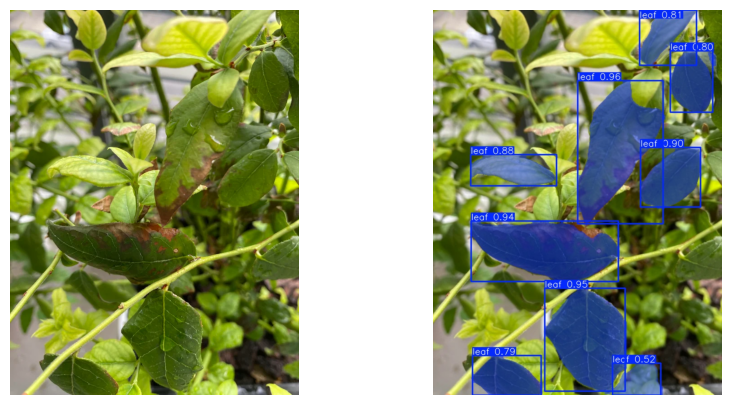

In [10]:
import matplotlib.pyplot as plt

def img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img(img_path))
axs[1].imshow(img(os.path.join(results[0].save_dir, os.path.basename(img_path).replace(".webp", ".jpg"))))
axs[0].axis("off")
axs[1].axis("off")


In [8]:
def resize_with_padding(image, target_size=(256, 256), padding_color=(0, 0, 0)):
    """
    Resize an image while maintaining aspect ratio by adding padding.
    
    Args:
        image: Input image (numpy array).
        target_size: Desired output size (width, height).
        padding_color: Color of the padding (BGR format).
    
    Returns:
        Padded and resized image.
    """
    h, w = image.shape[:2]
    target_w, target_h = target_size

    # Compute scale to fit within target size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image while maintaining aspect ratio
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Compute padding (equal on both sides if necessary)
    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2

    # Apply padding to center the image
    padded = cv2.copyMakeBorder(
        resized, pad_h, target_h - new_h - pad_h, pad_w, target_w - new_w - pad_w,
        borderType=cv2.BORDER_CONSTANT, value=padding_color
    )

    return padded

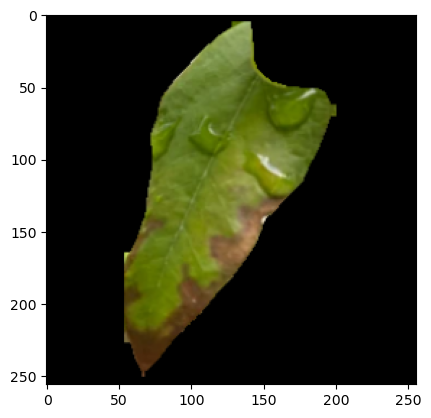

0


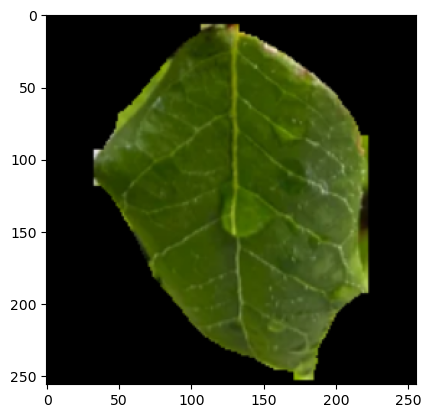

1


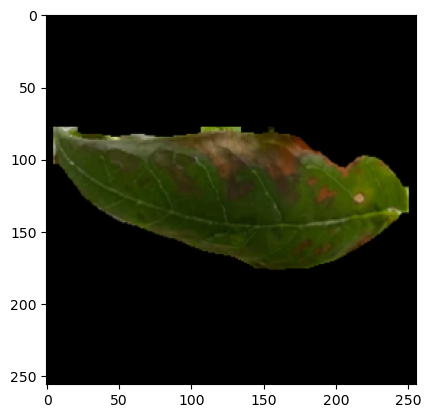

2


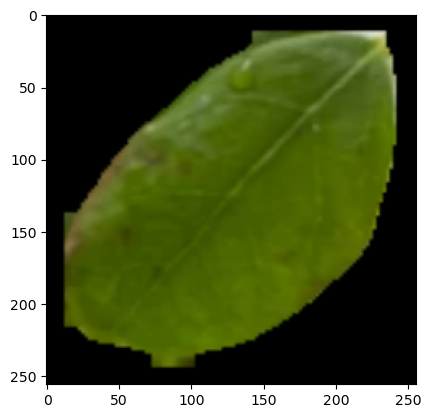

3


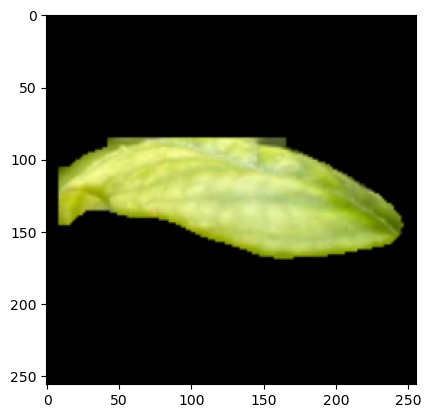

4


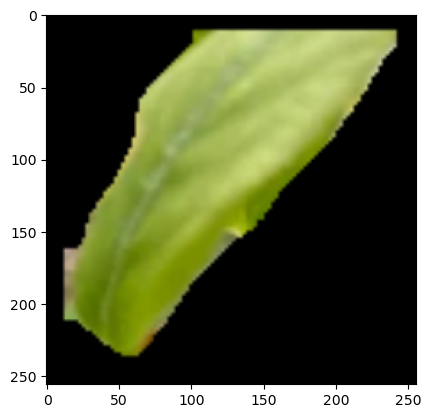

5


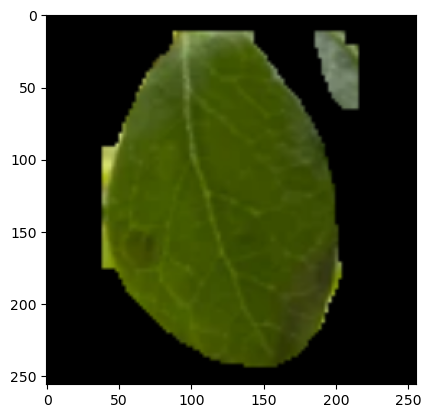

6


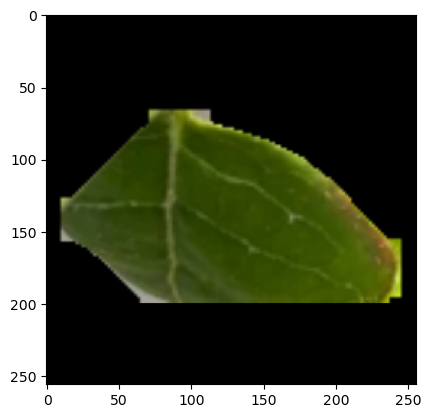

7


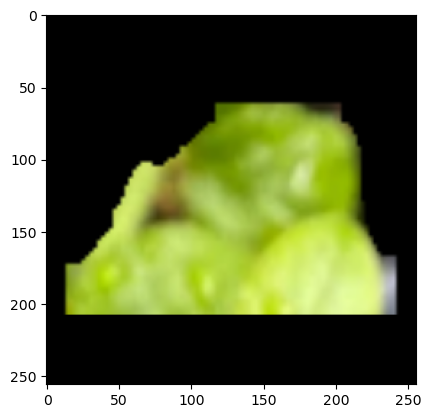

8


In [92]:
image = img(img_path)

# Get bounding boxes and masks
mask_array = results[0].masks.data.cpu().numpy()  # (num_objects, height, width)
masks = []

for mask in mask_array:
    image = cv2.resize(image, (480, 640))
    mask = mask.astype(np.uint8)
    result = cv2.bitwise_and(image, image, mask=mask)
    # Find non-zero coordinates (object region)
    coords = cv2.findNonZero(mask)  # Get coordinates of non-black pixels
    x, y, w, h = cv2.boundingRect(coords)  # Get bounding box

    # Crop the result to the bounding box
    cropped_result = result[max(0, y-5):y+h+5, max(0, x-5):x+w+5]
    cropped_result = resize_with_padding(cropped_result)
    # Save the segmented object
    masks.append(cropped_result)
    
for i in range(len(masks)):
    plt.imshow(masks[i])
    plt.show()
    print(i)